In [4]:
from autogen import retrieve_utils

paper = retrieve_utils.extract_text_from_pdf("data/paper.pdf")
print(paper)

GraphReader: Building Graph-based Agent to Enhance
Long-Context Abilities of Large Language Models
Shilong Li∗1, Yancheng He∗1, Hangyu Guo∗1, Xingyuan Bu∗†‡1, Ge Bai1, Jie Liu2,3,
Jiaheng Liu1, Xingwei Qu4, Yangguang Li3, Wanli Ouyang2,3, Wenbo Su1, Bo Zheng1
1Alibaba Group2The Chinese University of Hong Kong
3Shanghai AI Laboratory4University of Manchester
{zhuli.lsl, buxingyuan.bxy}@taobao.com
Abstract
Long-context capabilities are essential for large
language models (LLMs) to tackle complex
and long-input tasks. Despite numerous efforts
made to optimize LLMs for long contexts, chal-
lenges persist in robustly processing long in-
puts. In this paper, we introduce GraphReader,
a graph-based agent system designed to han-
dle long texts by structuring them into a graph
and employing an agent to explore this graph
autonomously. Upon receiving a question, the
agent first undertakes a step-by-step analysis
and devises a rational plan. It then invokes a
set of predefined functions to read n

In [5]:
import os
from autogen import ConversableAgent

agent = ConversableAgent(
    "chatbot",
    llm_config={"config_list": [{"model": "gpt-4o-mini", "api_key": os.environ.get("OPENAI_API_KEY")}]},
    code_execution_config=False,  # Turn off code execution, by default it is off.
    function_map=None,  # No registered functions, by default it is None.
    human_input_mode="NEVER",  # Never ask for human input.
)

[autogen.oai.client: 09-11 13:32:12] {184} WARNING - The API key specified is not a valid OpenAI format; it won't work with the OpenAI-hosted model.


In [6]:
key_atom_prompt = """
You are now an intelligent assistant tasked with meticulously extracting both key elements and atomic facts from a long text. 1. Key Elements: The essential nouns (e.g., characters, times, events, places, numbers), verbs (e.g., actions), and adjectives (e.g., states, feelings) that are pivotal to the text’s narrative. 2. Atomic Facts: The smallest, indivisible facts, presented as concise sentences. These include propositions, theories, existences, concepts, and implicit elements like logic, causality, event sequences, interpersonal relationships, timelines, etc.  Requirements: ##### 1. Ensure that all identified key elements are reflected within the corresponding atomic facts. 2. You should extract key elements and atomic facts comprehensively, especially those that are important and potentially query-worthy and do not leave out details. 3. Whenever applicable, replace pronouns with their specific noun counterparts (e.g., change I, He, She to actual names). 4. Ensure that the key elements and atomic facts you extract are presented in the same language as the original text (e.g., English or Chinese). 5. You should output a total of key elements and atomic facts that do not exceed 1024 tokens. 6. Your answer format for each line should be: [Serial Number], [Atomic Facts], [List of Key Elements, separated with ‘|’] #####  Example: ##### User: One day, a father and his little son ......  Assistant: 1. One day, a father and his little son were going home. | father | little son | going home 2. ...... #####  Please strictly follow the above format. Let’s begin.
"""


In [6]:
reply = agent.generate_reply(messages=[{"content": paper, "role": "system"},{"content": "Find flaws in this paper's methods.", "role": "user"}])
print(reply)

Here are several potential flaws in the methods of the paper "GraphReader: Building Graph-based Agent to Enhance Long-Context Abilities of Large Language Models":

1. **Dependence on Graph Construction**: The effectiveness of GraphReader relies heavily on the quality and completeness of the graph constructed from the text. If key elements or atomic facts are missed during the extraction, the subsequent exploration and reasoning may lead to incomplete or incorrect answers. The method describes normalization and linking processes, but these may not always guarantee that the most relevant information is represented in the graph.

2. **Chunking Limitations**: The authors divide long texts into chunks while preserving paragraph structures. However, this approach may not always capture the necessary context for complex multi-hop questions. Key information might be divided across adjacent chunks, leading to incomplete understanding or loss of critical relationships between facts. Additionally

In [7]:
chunks = retrieve_utils.split_text_to_chunks(paper, 300, "multi_lines")

chunk_dict = {i: chunk for i, chunk in enumerate(chunks)}


max_tokens is too small to fit a single line of text. Breaking this line:
	GraphReader: Building Graph-based Agent to Enhance ...
Failed to split docs with must_break_at_empty_line being True, set to False.


In [8]:
reply = agent.generate_reply(
    messages=[
        {"content": key_atom_prompt, "role": "system"},
        {"content": chunks[0], "role": "user"},
    ]
)
print(reply)

1. Long-context capabilities are essential for large language models (LLMs) to tackle complex and long-input tasks. | Long-context capabilities | large language models | complex | long-input tasks  
2. Numerous efforts have been made to optimize LLMs for long contexts, yet challenges persist in robustly processing long inputs. | Numerous efforts | optimize | LLMs | long contexts | challenges | robustly processing | long inputs  
3. This paper introduces GraphReader, a graph-based agent system designed to handle long texts. | GraphReader | graph-based agent system | handle | long texts  
4. GraphReader structures long texts into a graph and employs an agent to explore this graph autonomously. | GraphReader | structures | long texts | graph | agent | explore | autonomously  
5. Upon receiving a question, the agent first undertakes a step-by-step analysis and devises a rational plan. | agent | receiving | question | undertakes | step-by-step analysis | devises | rational plan  
6. The age

In [8]:
def convert_to_dict(text):
    lines = text.strip().split("\n")
    result = {}

    for line in lines:
        try:
            parts = line.split("|")
            sentence = parts[0].split(".", 1)[1].strip()
            keys = [key.strip() for key in parts[1:]]

            for key in keys:
                if key in result:
                    result[key].append(sentence)
                else:
                    result[key] = [sentence]
        except IndexError:
            # If split fails, skip this line and continue with the next
            continue

    return result

In [12]:
converted_dict = convert_to_dict(reply)
converted_dict

{'Long-context capabilities': ['Long-context capabilities are essential for large language models (LLMs) to tackle complex and long-input tasks.'],
 'large language models': ['Long-context capabilities are essential for large language models (LLMs) to tackle complex and long-input tasks.'],
 'complex': ['Long-context capabilities are essential for large language models (LLMs) to tackle complex and long-input tasks.'],
 'long-input tasks': ['Long-context capabilities are essential for large language models (LLMs) to tackle complex and long-input tasks.'],
 'Numerous efforts': ['Numerous efforts have been made to optimize LLMs for long contexts, yet challenges persist in robustly processing long inputs.'],
 'optimize': ['Numerous efforts have been made to optimize LLMs for long contexts, yet challenges persist in robustly processing long inputs.'],
 'LLMs': ['Numerous efforts have been made to optimize LLMs for long contexts, yet challenges persist in robustly processing long inputs.'],


In [9]:
import nltk
from nltk.stem import PorterStemmer
from sklearn.cluster import DBSCAN
from sentence_transformers import SentenceTransformer
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd
import re
from collections import Counter

nltk.download("punkt")

c:\Users\12700K\Documents\Projects\VLOG-GraphReader\vlog_greader\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\12700K\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [122]:
def frequency_filtering(tag_dict, alpha):
    """Filter out tags appearing less than alpha times."""
    tag_counts = Counter()
    for tag, values in tag_dict.items():
        tag_counts[tag] += len(values)

    return {tag: values for tag, values in tag_dict.items() if tag_counts[tag] >= alpha}


def rule_aggregation(tag_dict):
    ps = PorterStemmer()
    new_dict = {}
    for tag, values in tag_dict.items():
        new_tag = ps.stem(re.sub(r"[^a-zA-Z0-9\s]", " ", tag.lower()))
        if new_tag in new_dict:
            new_dict[new_tag].extend(values)
            new_dict[new_tag] = list(set(new_dict[new_tag]))
        else:
            new_dict[new_tag] = values.copy()
    return new_dict


def semantic_aggregation(tag_dict, threshold):
    """Cluster tags based on semantic similarity using DBSCAN."""
    model = SentenceTransformer("sentence-transformers/paraphrase-MiniLM-L6-v2")
    tags = list(tag_dict.keys())
    embeddings = model.encode(tags)
    clustering = DBSCAN(eps=threshold, min_samples=1).fit(embeddings)
    new_dict = {}
    for i, label in enumerate(clustering.labels_):
        if label == -1:
            new_dict[tags[i]] = tag_dict[tags[i]]
        else:
            cluster_tags = [
                tags[j] for j, l in enumerate(clustering.labels_) if l == label
            ]
            new_key = min(cluster_tags, key=len)
            if new_key not in new_dict:
                new_dict[new_key] = []
            for tag in cluster_tags:
                new_dict[new_key].extend(tag_dict[tag])
            new_dict[new_key] = list(set(new_dict[new_key]))

    return new_dict


def association_aggregation(tag_dict, min_support):
    """Merge associated tags using FP-Growth algorithm."""
    tags = [list(tag_dict.keys())]
    te = pd.get_dummies(pd.DataFrame(tags)).astype(bool)
    frequent_itemsets = pd.DataFrame(
        fpgrowth(te, min_support=min_support, use_colnames=True)
    )

    new_dict = {}
    for _, row in frequent_itemsets.iterrows():
        if len(row["itemsets"]) > 1:
            new_key = " ".join(sorted(row["itemsets"]))
            new_dict[new_key] = []
            for tag in row["itemsets"]:
                tag = tag.split('_', 1)[1]
                new_dict[new_key].extend(tag_dict[tag])
                tag_dict.pop(tag, None)
            new_dict[new_key] = list(set(new_dict[new_key]))
    new_dict.update(tag_dict)  # Add remaining unmerged tags
    return new_dict


def aggregate_tags(
    tag_dict, alpha=3, semantic_threshold=6, association_min_support=1.2
):
    """Aggregate tags using all methods."""
    filtered_dict = frequency_filtering(tag_dict, alpha)
    aggregated_dict = rule_aggregation(filtered_dict)
    semantically_aggregated_dict = semantic_aggregation(
        aggregated_dict, semantic_threshold
    )
    final_dict = association_aggregation(
        semantically_aggregated_dict, association_min_support
    )
    return final_dict


In [82]:
aggregate_tags(converted_dict)

c:\Users\12700K\Documents\Projects\VLOG-GraphReader\vlog_greader\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


{'long context cap': ['Long-context capabilities are essential for large language models (LLMs) to tackle complex and long-input tasks.'],
 'large language model': ['Long-context capabilities are essential for large language models (LLMs) to tackle complex and long-input tasks.'],
 'complex': ['Long-context capabilities are essential for large language models (LLMs) to tackle complex and long-input tasks.'],
 'long input task': ['Long-context capabilities are essential for large language models (LLMs) to tackle complex and long-input tasks.'],
 'numerous effort': ['Numerous efforts have been made to optimize LLMs for long contexts, yet challenges persist in robustly processing long inputs.'],
 'optim': ['Numerous efforts have been made to optimize LLMs for long contexts, yet challenges persist in robustly processing long inputs.'],
 'llm': ['Numerous efforts have been made to optimize LLMs for long contexts, yet challenges persist in robustly processing long inputs.'],
 'long context':

In [49]:
def extend_and_merge_dict(original_dict, new_dict):
    """
    Extends the original dictionary with a new dictionary,
    merging and deduplicating value lists for common keys.

    :param original_dict: The dictionary to be extended
    :param new_dict: The dictionary to extend with
    :return: The extended and merged dictionary
    """
    for key, new_values in new_dict.items():
        if key in original_dict:
            # Merge lists and remove duplicates
            original_dict[key] = list(set(original_dict[key] + new_values))
        else:
            # Add new key-value pair
            original_dict[key] = new_values

    return original_dict


# Example usage
dict1 = {
    "Python": ["is a programming language", "is used for data science"],
    "AI": ["stands for Artificial Intelligence"],
}

dict2 = {
    "Python": ["is popular", "is used for data science"],
    "Machine Learning": ["is a subset of AI"],
}

result = extend_and_merge_dict(dict1, dict2)
for key, value in result.items():
    print(f"{key}: {value}")

Python: ['is a programming language', 'is used for data science', 'is popular']
AI: ['stands for Artificial Intelligence']
Machine Learning: ['is a subset of AI']


In [53]:
import warnings
import datetime

warnings.filterwarnings(action="ignore", message=r"datetime.datetime.utcnow")

In [57]:
greader_dict = {}
chunk_dict = {}
for i, chunk in enumerate(chunks):
    reply = agent.generate_reply(
        messages=[
            {"content": key_atom_prompt, "role": "system"},
            {"content": chunk, "role": "user"},
        ]
    )
    new_dict = convert_to_dict(reply)
    for _, values in new_dict.items():
        for value in values:
            chunk_dict[value] = i
    greader_dict = extend_and_merge_dict(greader_dict, new_dict)

In [107]:
len(greader_dict)

1774

In [123]:
agg_greader = aggregate_tags(greader_dict)
print(len(agg_greader))

c:\Users\12700K\Documents\Projects\VLOG-GraphReader\vlog_greader\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


121


In [15]:
import networkx as nx
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt

In [62]:
def construct_graph(dictionary, similarity_threshold=80):
    """
    Construct a graph from a dictionary where nodes are keys and attributes are values.
    Edges are created based on fuzzy matching of keys in other nodes' attributes.

    :param dictionary: Input dictionary
    :param similarity_threshold: Threshold for fuzzy matching (0-100)
    :return: NetworkX graph
    """
    G = nx.Graph()

    # Add nodes with attributes
    for key, values in dictionary.items():
        G.add_node(key, values=values)

    # Add edges based on fuzzy matching
    nodes = list(G.nodes())
    for i, node1 in enumerate(nodes):
        for node2 in nodes[i + 1 :]:
            # Check if node1's key is in node2's values or vice versa
            for value in G.nodes[node2]["values"]:
                if (
                    fuzz.partial_ratio(node1.lower(), value.lower())
                    >= similarity_threshold
                ):
                    G.add_edge(node1, node2)
                    break
            if not G.has_edge(node1, node2):
                for value in G.nodes[node1]["values"]:
                    if (
                        fuzz.partial_ratio(node2.lower(), value.lower())
                        >= similarity_threshold
                    ):
                        G.add_edge(node1, node2)
                        break

    return G


def visualize_graph(G):
    """
    Visualize the graph using matplotlib.

    :param G: NetworkX graph
    """
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 8))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color="lightblue",
        node_size=3000,
        font_size=10,
        font_weight="bold",
    )

    # Add node attributes as labels
    node_attrs = nx.get_node_attributes(G, "values")
    pos_attrs = {}
    for node, coords in pos.items():
        pos_attrs[node] = (coords[0], coords[1] - 0.08)
    nx.draw_networkx_labels(
        G,
        pos_attrs,
        {node: "\n".join(attrs) for node, attrs in node_attrs.items()},
        font_size=8,
        font_color="red",
    )

    plt.axis("off")
    plt.tight_layout()
    plt.show()

C:\Users\12700K\AppData\Local\Temp\ipykernel_22304\1202717305.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


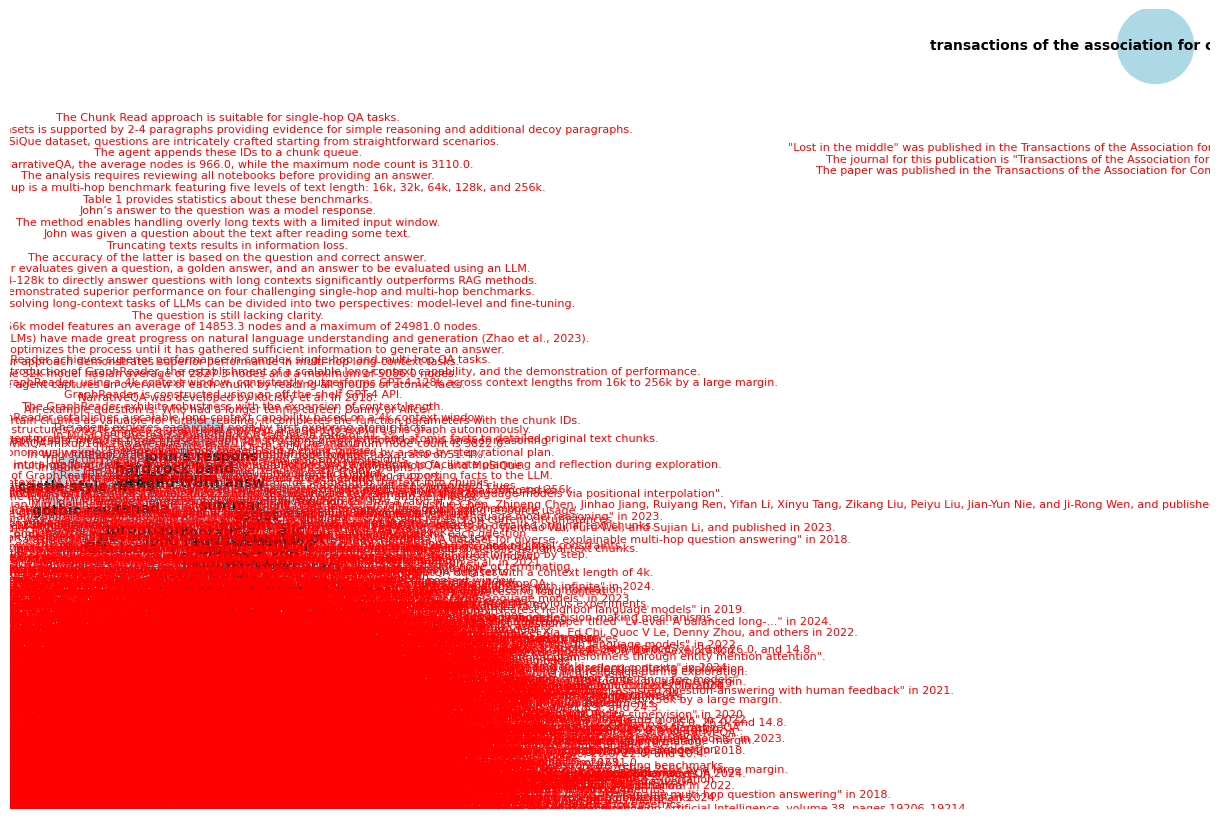

In [124]:
greader_graph = construct_graph(agg_greader)
visualize_graph(greader_graph)

In [125]:
# Print node attributes
for node in greader_graph.nodes():
    print(f"{node}: {greader_graph.nodes[node]['values']}")

# Print edges
print("\nEdges:")
for edge in greader_graph.edges():
    print(edge)

large language model: ['Keming Lu, Hongyi Yuan, Zheng Yuan, Runji Lin, Junyang Lin, Chuanqi Tan, Chang Zhou, and Jingren Zhou presented "#instag: Instruction tagging for analyzing supervised fine-tuning of large language models" in 2023.', 'Yukang Chen, Shengju Qian, Haotian Tang, Xin Lai, Zhijian Liu, Song Han, and Jiaya Jia published a paper in 2023 titled "Longlora: Efficient fine-tuning of long-context large language models".', 'Long-context capabilities are essential for large language models (LLMs) to tackle complex and long-input tasks.', 'Yushi Bai, Xin Lv, Jiajie Zhang, Yuze He, Ji Qi, Lei Hou, Jie Tang, Yuxiao Dong, and Juanzi Li authored the paper titled "Longalign: A recipe for long context alignment of large language models."', 'Shouyuan Chen, Sherman Wong, Liangjian Chen, and Yuandong Tian published a paper in 2023 titled "Extending context window of large language models via positional interpolation".', 'Large language models (LLMs) have made great progress on natural la

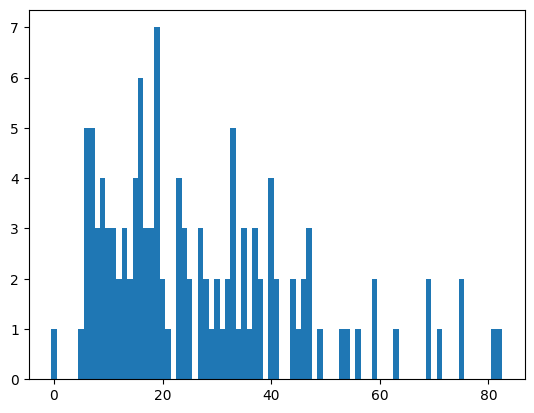

In [126]:
hist = nx.degree_histogram(greader_graph)
plt.bar(range(len(hist)), hist, width=1)
plt.show()

In [139]:
from collections import deque
import autogen
import re
import ast

In [127]:
G = greader_graph

In [150]:
ration_plan_prompt = """
As an intelligent assistant, your primary objective is to answer the question by gathering supporting facts from a given article. To facilitate this objective, the first step is to make a rational plan based on the question. This plan should outline the step-by-step process to resolve the question and specify the key information required to formulate a comprehensive answer.  Example: ##### User: Who had a longer tennis career, Danny or Alice?  Assistant: In order to answer this question, we first need to find the length of Danny’s and Alice’s tennis careers, such as the start and retirement of their careers, and then compare the two. #####  Please strictly follow the above format. Let’s begin.
"""
node_selection_prompt = """
As an intelligent assistant, your primary objective is to answer questions based on information contained within a text. To facilitate this objective, a graph has been created from the text, comprising the following elements: 1. Text Chunks: Chunks of the original text. 2. Atomic Facts: Smallest, indivisible truths extracted from text chunks. 3. Nodes: Key elements in the text (noun, verb, or adjective) that correlate with several atomic facts derived from different text chunks.  Your current task is to check a list of nodes, with the objective of selecting the most relevant initial nodes from the graph to efficiently answer the question. You are given the question, the rational plan, and a list of node key elements. These initial nodes are crucial because they are the starting point for searching for relevant information.  Requirements: ##### 1. Once you have selected a starting node, assess its relevance to the potential answer by assigning a score between 0 and 100. A score of 100 implies a high likelihood of relevance to the answer, whereas a score of 0 suggests minimal relevance. 2. Present each chosen starting node in a separate line, accompanied by its relevance score. Format each line as follows: Node: [Key Element of Node], Score: [Relevance Score]. 3. Please select at least 10 starting nodes, ensuring they are non-repetitive and diverse. 4. In the user’s input, each line constitutes a node. When selecting the starting node, please make your choice from those provided, and refrain from fabricating your own. The nodes you output must correspond exactly to the nodes given by the user, with identical wording. #####  Example: ##### User: Question: {QUESTION} Plan: {RATIONAL PLAN} Nodes: {LIST OF KEY ELEMENTS}  Assistant:{LIST OF SELECTED NODES} #####  Finally, I emphasize again that you need to select the starting node from the given Nodes, and it must be consistent with the words of the node you selected. Please strictly follow the above format. Let’s begin.
"""
explore_fact_prompt = """
As an intelligent assistant, your primary objective is to answer questions based on information contained within a text. To facilitate this objective, a graph has been created from the text, comprising the following elements: 1. Text Chunks: Chunks of the original text. 2. Atomic Facts: Smallest, indivisible truths extracted from text chunks. 3. Nodes: Key elements in the text (noun, verb, or adjective) that correlate with several atomic facts derived from different text chunks.  Your current task is to check a node and its associated atomic facts, with the objective of determining whether to proceed with reviewing the text chunk corresponding to these atomic facts. Given the question, the rational plan, previous actions, notebook content, and the current node’s atomic facts and their corresponding chunk IDs, you have the following Action Options: ##### 1. read_chunk(List[ID]): Choose this action if you believe that a text chunk linked to an atomic fact may hold the necessary information to answer the question. This will allow you to access more complete and detailed information. 2. stop_and_read_neighbor(): Choose this action if you ascertain that all text chunks lack valuable information. #####  Strategy: ##### 1. Reflect on previous actions and prevent redundant revisiting nodes or chunks. 2. You can choose to read multiple text chunks at the same time. 3. Atomic facts only cover part of the information in the text chunk, so even if you feel that the atomic facts are slightly relevant to the question, please try to read the text chunk to get more complete information. #####  Response format: ##### *Updated Notebook*: First, combine your current notebook with new insights and findings about the question from current atomic facts, creating a more complete version of the notebook that contains more valid information. *Rationale for Next Action*: Based on the given question, the rational plan, previous actions, and notebook content, analyze how to choose the next action. *Chosen Action*: read_chunk(List[ID]) or stop_and_read_neighbor(). (Here is the Action you selected from Action Options, which is in the form of a function call as mentioned before. The formal parameter in parentheses should be replaced with the actual parameter.) #####  Finally, it is emphasized again that even if the atomic fact is only slightly relevant to the question, you should still look at the text chunk to avoid missing information. You should only choose stop_and_read_neighbor() when you are very sure that the given text chunk is irrelevant to the question. Please strictly follow the above format. Let’s begin.
"""
explore_chunk_prompt = """
As an intelligent assistant, your primary objective is to answer questions based on information within a text. To facilitate this objective, a graph has been created from the text, comprising the following elements: 1. Text Chunks: Segments of the original text. 2. Atomic Facts: Smallest, indivisible truths extracted from text chunks. 3. Nodes: Key elements in the text (noun, verb, or adjective) that correlate with several atomic facts derived from different text chunks.  Your current task is to assess a specific text chunk and determine whether the available information suffices to answer the question. Given the question, rational plan, previous actions, notebook content, and the current text chunk, you have the following Action Options: ##### 1. search_more(): Choose this action if you think that the essential information necessary to answer the question is still lacking. 2. read_previous_chunk(): Choose this action if you feel that the previous text chunk contains valuable information for answering the question. 3. read_subsequent_chunk(): Choose this action if you feel that the subsequent text chunk contains valuable information for answering the question. 4. termination(): Choose this action if you believe that the information you have currently obtained is enough to answer the question. This will allow you to summarize the gathered information and provide a final answer. #####  Strategy: ##### 1. Reflect on previous actions and prevent redundant revisiting of nodes or chunks. 2. You can only choose one action. #####  Response format: ##### *Updated Notebook*: First, combine your previous notes with new insights and findings about the question from current text chunks, creating a more complete version of the notebook that contains more valid information. *Rationale for Next Action*: Based on the given question, rational plan, previous actions, and notebook content, analyze how to choose the next action. *Chosen Action*: search_more() or read_previous_chunk() or read_subsequent_chunk() or termination(). (Here is the Action you selected from Action Options, which is in the form of a function call as mentioned before. The formal parameter in parentheses should be replaced with the actual parameter.) #####  Please strictly follow the above format. Let’s begin.
"""
explore_neighbor_prompt = """
As an intelligent assistant, your primary objective is to answer questions based on information within a text. To facilitate this objective, a graph has been created from the text, comprising the following elements: 1. Text Chunks: Segments of the original text. 2. Atomic Facts: Smallest, indivisible truths extracted from text chunks. 3. Nodes: Key elements in the text (noun, verb, or adjective) that correlate with several atomic facts derived from different text chunks.  Your current task is to assess all neighboring nodes of the current node, with the objective of determining whether to proceed to the next neighboring node. Given the question, rational plan, previous actions, notebook content, and the neighbors of the current node, you have the following Action Options: ##### 1. read_neighbor_node(key element of node): Choose this action if you believe that any of the neighboring nodes may contain information relevant to the question. Note that you should focus on one neighbor node at a time. 2. termination(): Choose this action if you believe that none of the neighboring nodes possess information that could answer the question. #####  Strategy: ##### 1. Reflect on previous actions and prevent redundant revisiting of nodes or chunks. 2. You can only choose one action. This means that you can choose to read only one neighbor node or choose to terminate. #####  Response format: ##### *Rationale for Next Action*: Based on the given question, rational plan, previous actions, and notebook content, analyze how to choose the next action. *Chosen Action*: read_neighbor_node(neighbor_node) or termination(). (Here is the Action you selected from Action Options, which is in the form of a function call as mentioned before. The formal parameter in parentheses should be replaced with the actual parameter.) #####  Please strictly follow the above format. Let’s begin.
"""
answer_reason_prompt = """
As an intelligent assistant, your primary objective is to answer questions based on information within a text. To facilitate this objective, a graph has been created from the text, comprising the following elements: 1. Text Chunks: Segments of the original text. 2. Atomic Facts: Smallest, indivisible truths extracted from text chunks. 3. Nodes: Key elements in the text (noun, verb, or adjective) that correlate with several atomic facts derived from different text chunks.  You have now explored multiple paths from various starting nodes on this graph, recording key information for each path in a notebook. Your task now is to analyze these memories and reason to answer the question.  Strategy: ##### 1. You should first analyze each notebook content before providing a final answer. 2. During the analysis, consider complementary information from other notes and employ a majority voting strategy to resolve any inconsistencies. 3. When generating the final answer, ensure that you take into account all available information. #####  Example: ##### User: Question: Who had a longer tennis career, Danny or Alice? Notebook of different exploration paths: 1. We only know that Danny’s tennis career started in 1972 and ended in 1990, but we don’t know the length of Alice’s career. 2. ......  Assistant: Analyze: The summary of search path 1 points out that Danny’s tennis career is 1990-1972=18 years. Although it does not indicate the length of Alice’s career, the summary of search path 2 finds this information, that is, the length of Alice’s tennis career is 15 years. Then we can get the final answer, that is, Danny’s tennis career is longer than Alice’s. Final answer: Danny’s tennis career is longer than Alice’s. #####  Please strictly follow the above format. Let’s begin.
"""


In [170]:
class Notebook:
    def __init__(self):
        self.notes = ""

    def add_note(self, note):
        self.notes += f"\n{note}"

    def set_note(self, note):
        self.notes = note

    def get_notes(self):
        return self.notes

    def clear(self):
        self.notes = ""


def string_to_int_list(s):
    # Remove any whitespace and convert to a Python literal
    cleaned_s = s.strip()
    # Use ast.literal_eval to safely evaluate the string as a Python expression
    list_of_strings = ast.literal_eval(cleaned_s)
    # Convert each element to an integer
    return [int(x) for x in list_of_strings]

def match_function_call(x):
    pattern = r"(\w+)\((.*?)\)"
    match = re.match(pattern, x)
    if match:
        function_name, param = match.groups()
        return function_name, param
    else:
        return None


def format_values(node):
    values = G.nodes[node]["values"]
    value_id = "\n"
    for value in values:
        value_id += f"Atomic Fact: {value} Chunk ID: {chunk_dict[value]}\n"
    return value_id

def get_initial_node_list(initial_nodes):
    initial_node_list = []
    for node_info in initial_nodes.split('\n'):
        if node_info.strip():
            node_parts = node_info.split(',')
            if len(node_parts) >= 1:
                node_element = node_parts[0].split(':')[1].strip()
                initial_node_list.append(node_element)
    return initial_node_list

def extract_notebook_and_action(input_string):
    # Extract notebook content
    start_index = input_string.find("*Updated Notebook*:")
    end_index = input_string.find("*Rationale for Next Action*:")
    print(start_index, end_index)
    if start_index != -1 and end_index != -1:
        notebook = input_string[start_index:end_index].strip()
    else:
        notebook = ""

    # Extract action
    action_start = input_string.find("*Chosen Action*:") + len("*Chosen Action* :")
    action = input_string[action_start:].strip() if action_start != -1 else ""

    return notebook, action


class GraphExplorerAgent(autogen.ConversableAgent):
    def __init__(self, name):
        super().__init__(
            name=name,
            system_message="""You are an AI assistant designed to answer questions. 
            You have access to a graph containing relevant information. Your task is to explore the graph, collect information, and provide answers based on your exploration.
            """,
            llm_config={
                "config_list": [
                    {"model": "gpt-4", "api_key": os.environ.get("OPENAI_API_KEY")}
                ]
            },
        )
        self.exploration_queue = deque()
        self.explored_nodes = set()
        self.actions = ""
        self.question = ""
        self.plan = ""
        self.notebook = Notebook()
        self.terminate = False

    def explore_graph(self, question):
        self.notebook.clear()
        self.exploration_queue = deque()
        self.explored_nodes = set()
        self.question = question
        # Step 1: Analyze question and create plan
        self.plan = self.create_plan()

        # Step 2: Choose initial node
        initial_nodes = self.choose_initial_node()
        initial_nodes = get_initial_node_list(initial_nodes)
        self.exploration_queue.extend(initial_nodes)

        while self.exploration_queue and not self.terminate:
            current_node = self.exploration_queue.popleft()
            if current_node in self.explored_nodes:
                continue

            
            node_info = self.read_node(current_node)
            print(node_info)
            note, action = extract_notebook_and_action(node_info)
            self.notebook.set_note(note)
            self.actions += f"\n{action}"
            print(action)
            function_name, param = match_function_call(action)
            match function_name:
                case "read_chunk":
                    param = string_to_int_list(param)
                    self.read_chunk(param)
                case "stop_and_read_neighbor()":
                    self.stop_and_read_neighbor(current_node)
            self.explored_nodes.add(current_node)

        # Step 6: Provide final answer
        return self.provide_final_answer()

    def read_node(self, node_name):
        if node_name in G.nodes:
            response = self.generate_reply(
                messages=[
                    {
                        "role": "system",
                        "content": explore_fact_prompt,
                    },
                    {
                        "role": "user",
                        "content": f"Question: {self.question}\nPlan: {self.plan}\nActions: {self.actions}\nNotebook: {self.notebook.get_notes()}\nAtomic Facts: {format_values(node_name)}",
                    },
                ]
            )
            return response
        else:
            return f"Node '{node_name}' not found in the graph."
    
    def stop_and_read_neighbor(self, current_node):
        response = self.generate_reply(
            messages=[
                {
                    "role": "system",
                    "content": explore_fact_prompt,
                },
                {
                    "role": "user",
                    "content": f"Question: {self.question}\nPlan: {self.plan}\nActions: {self.actions}\nNotebook: {self.notebook.get_notes()}\nNeighbors: {"\n".join(G.neighbors(current_node))}",
                },
            ]
        )
        _, action = extract_notebook_and_action(response)
        self.actions += f"\n{action}"
        function_name, param = match_function_call(action)
        match function_name:
            case "read_neighbor_node":
                self.exploration_queue.appendleft(param)
            case "termination":
                self.terminate = True
                return

    def read_chunk(self, chunk_ids):
        chunk_ids = deque(chunk_ids)
        while chunk_ids:
            chunk_id = chunk_ids.popleft()
            chunk = chunks[chunk_id]
            response = self.generate_reply(
                messages=[
                    {
                        "role": "system",
                        "content": explore_chunk_prompt,
                    },
                    {
                        "role": "user",
                        "content": f"Question: {self.question}\nPlan: {self.plan}\nActions: {self.actions}\nNotebook: {self.notebook.get_notes()}\nChunk: \n{chunk}",
                    },
                ]
            )
            note, action = extract_notebook_and_action(response)
            self.notebook.set_note(note)
            self.actions += f"\n{action}"
            match action:
                case "search_more()":
                    continue
                case "read_previous_chunk()":
                    if chunk_id > 0:
                        chunk_ids.appendleft(chunk_id - 1)
                case "read_subsequent_chunk()":
                    if chunk_id < len(chunks) - 1:
                        chunk_ids.appendleft(chunk_id + 1)
                case "termination()":
                    self.terminate = True
                    return
            return

    def create_plan(self):
        response = self.generate_reply(
            messages=[
                {
                    "role": "system",
                    "content": ration_plan_prompt,
                },
                {"role": "user", "content": self.question}
            ]
        )
        return response

    def choose_initial_node(self):
        nodes = list(G.nodes)
        response = self.generate_reply(
            messages=[
                {
                    "role": "system",
                    "content": node_selection_prompt,
                },
                {"role": "user", "content": f"Question: {self.question}\nPlan: {self.plan}\nNodes: {"\n".join(nodes)}"}
            ]
        )
        return response.strip()

    def provide_final_answer(self):
        response = self.generate_reply(
            messages=[
                {
                    "role": "system",
                    "content": answer_reason_prompt,
                },
                {"role": "user", "content": f"Question: {self.question}\nPlan: {self.plan}\nActions: {self.actions}\nNotebook: {self.notebook.get_notes()}"}
            ]
        )
        return response


# Create the GraphExplorerAgent
explorer = GraphExplorerAgent("GraphExplorer")

# Create a user proxy for interaction
user_proxy = autogen.UserProxyAgent(
    name="Human", human_input_mode="TERMINATE", max_consecutive_auto_reply=1, code_execution_config=False
)


# Function to handle the exploration process
def explore_and_answer(question):
    answer = explorer.explore_graph(question)
    return answer

[autogen.oai.client: 09-11 23:25:29] {184} WARNING - The API key specified is not a valid OpenAI format; it won't work with the OpenAI-hosted model.


In [171]:
# Start the conversation
explore_and_answer("Find me some of the results from this paper related to the performance metrics")



>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...
*Updated Notebook*: The paper compares methods and provides performance metrics: LR-1, LR-2, and F1 scores are measured. The performance metrics for BM25 (top-1) and BM25 (top-3) vary across different evaluation metrics, including precision for multiple datasets. Statistics like averages and maximums are included in the performance metrics. The performance metrics for LR-2 show scores like 18.0, 11.9, and 6.0 for increasing input sizes. The performance metrics for LR-1 correspond to scores such as 10.0, 16.0, 12.0 for 4k, 10k, and 16k inputs respectively. BM25 (top-1) also shows performance metrics for various input window sizes.

*Rationale for Next Action*: The atomic facts revealed the existence of performance metrics for LR-1, LR-2, F1 scores and also for two methods - BM25 (top-1) and BM25 (top-3). Each method has metrics that vary based on inputs and evaluation metrics. Further, statistics l

"Analyze: From the exploration, it is found that the paper presents several performance metrics, including LR-1, LR-2, F1 scores, precision, averages, maximums, Exact Match (EM) score, and an optimized F1* score. The paper computes these metrics across several benchmarks, including multi-hop long-context QA (HotpotQA, 2WikiMultihopQA, MuSiQue), a single-hop long-context QA benchmark (NarrativeQA) from LongBench, and HotpotWikiQA-mixup from LV-Eval, and different text lengths, ranging from 16k to 256k tokens. The results demonstrate that the ReadA-MethodInput and BM25 (top-1) methods significantly improve the performance metrics for these tasks. Particularly notable is the GraphReader, which outperforms GPT-4-128k across various context lengths, and particularly excels under a 4k context window, demonstrating a performance gain of 75.00% over GPT-4-128k for context length of 128k and a relative performance improvement of 10.53% on LR-1 under a 16k context. The paper also reports the Gra